In [1]:
import logging
import os
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

import numpy as np
import nets
import train
from arg import *
from lib import *
from main import *
from nni.utils import merge_parameter
from sklearn.metrics import confusion_matrix, f1_score,roc_curve,RocCurveDisplay,auc

In [2]:
#initialization
log = True
TRIAL_NAME = "315_15f" 
#TL_BASE = "state_dict/210106-1316_ap"
TL_BASE = ""
TRIAL_TIME = time.strftime("%y%m%d-%H%M", time.localtime())
#TL_BASE = "temp.dict"
#DATA_DIR = os.environ['imageDataPath']+'/408.4/ap'
DATA_DIR = '/mnt/ramdisk/315/ap'
fold_num = len(os.listdir(DATA_DIR))
torch.backends.cudnn.benchmark = True
if log:
    logger = set_logger(TRIAL_TIME, TRIAL_NAME)

args = vars(get_params())

args['TRIAL_TIME'] = TRIAL_TIME
args['TRIAL_NAME'] = TRIAL_NAME
args['fold_num'] = fold_num

#args['flood_level'] = 0.12#ptb
#args['epochs_num'] = 30 #ptb

logger.info(args)
torch.cuda.empty_cache()

# log information
logger.info("DATA_DIR:"+DATA_DIR)
logger.info("BASE ON:"+TL_BASE)
logger.info("TRAIN NAME:\""+TRIAL_NAME+"\"")

INFO:log:{'nni': False, 'sigmoid': False, 'normalization': True, 'weight_decay': 0.01, 'degrees': 15, 'xtras': 0.05, 'batch_size': 32, 'lr': 0.01, 'base_lr': 2e-05, 'max_lr': 0.002, 'flood_level': 0.12, 'momentum': 0.9, 'epochs_num': 9, 'step_size': 3, 'workers': 4, 'TRIAL_TIME': '210116-1920', 'TRIAL_NAME': '315_15f', 'fold_num': 5}
INFO:log:DATA_DIR:/mnt/ramdisk/315/ap
INFO:log:BASE ON:
INFO:log:TRAIN NAME:"315_15f"


In [3]:
def output_calc(output,label,alpha = 0.0):
    outputn = output[:,1]-output[:,0]
    #outputn = -outputn #inverse
    outputn = outputn/max([max(outputn),-min(outputn)])
    outputn = outputn/2+0.5
    pred = torch.round(outputn-alpha)
    acc = torch.sum(pred == label.data).item()/len(label)
    print(acc)
    con = confusion_matrix(pred.cpu(),label.cpu(),labels = [0,1])
    print(con)
    #TP TN
    #PP PN
    return outputn,con

In [4]:
#15
result = []
output = dict()
for fold in range(1, 6):
    for plane in [0, 1, 2]:
        torch.cuda.empty_cache()
        dataloaders = get_dataloaders(args, fold, fold_num, plane, DATA_DIR)
        tr = train.TrainRunner(args, logger, dataloaders, fold)
        run(args, tr)
        output[plane], label = tr.test()
        del tr
    calc_output = (output[0] + output[1] + output[2]) / 3
    _, pred = torch.max(calc_output, 1)
    logger.info("fold {} acc:{}".format(fold, sum(pred == label) / len(label)))
    logger.info("confusion_matrix:{}".format(confusion_matrix(pred, label)))
    result.append([output, label, calc_output])
torch.save(result, "result.allsave")

INFO:log:using device:: cuda:0
INFO:log:trainset sizes:
INFO:log:0_MI :7973
INFO:log:1_H  :8624
INFO:log:weights:[0.9607760310173035, 1.0392239093780518]
fold:1/5 epoch: -/9 | train loss: ------ acc: ------ N/A% |    | ETA:  --:--:--/home/rayfang/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
fold:1/5 epoch: 1/9 | train loss:   0.41 acc:    0.8 100% |####| Time:  0:01:09
fold:1/5 epoch: 1/9 | val   loss:  0.165 acc:  0.931 100% |####| Time:  0:00:05
INFO:log: 1/9 | 0.00068 | 0.4099 | 0.8004 | 0.7

confusion martix:
[[1862  100]
 [ 127 1536]]
[01/16/2021, 07:21:31 PM] INFO (nni) Intermediate result: 0.9425461908377627  (Index 0)


fold:1/5 epoch: 2/9 | train loss:  0.203 acc:  0.925 100% |####| Time:  0:01:03
fold:1/5 epoch: 2/9 | val   loss:  0.152 acc:  0.949 100% |####| Time:  0:00:05
INFO:log: 2/9 | 0.00134 | 0.2033 | 0.9254 | 0.9211 | 0.1525 | 0.9553 | 0.9588 || 1m9s


confusion martix:
[[1887   60]
 [ 102 1576]]
[01/16/2021, 07:22:42 PM] INFO (nni) Intermediate result: 0.9588414634146342  (Index 1)


fold:1/5 epoch: 3/9 | train loss:  0.168 acc:   0.95 100% |####| Time:  0:01:03
fold:1/5 epoch: 3/9 | val   loss:   0.23 acc:  0.875 100% |####| Time:  0:00:05
INFO:log: 3/9 | 0.00200 | 0.1677 | 0.9507 | 0.9480 | 0.2310 | 0.8803 | 0.8978 || 1m9s


confusion martix:
[[1907  352]
 [  82 1284]]
[01/16/2021, 07:23:53 PM] INFO (nni) Intermediate result: 0.897834274952919  (Index 2)


fold:1/5 epoch: 4/9 | train loss:  0.153 acc:  0.966 100% |####| Time:  0:01:04
fold:1/5 epoch: 4/9 | val   loss:  0.212 acc:  0.894 100% |####| Time:  0:00:05
INFO:log: 4/9 | 0.00134 | 0.1535 | 0.9666 | 0.9648 | 0.2133 | 0.9001 | 0.9138 || 1m9s


confusion martix:
[[1919  292]
 [  70 1344]]
[01/16/2021, 07:25:04 PM] INFO (nni) Intermediate result: 0.9138095238095238  (Index 3)


fold:1/5 epoch: 5/9 | train loss:  0.146 acc:  0.975 100% |####| Time:  0:01:04
fold:1/5 epoch: 5/9 | val   loss:  0.222 acc:  0.884 100% |####| Time:  0:00:05
INFO:log: 5/9 | 0.00068 | 0.1461 | 0.9756 | 0.9744 | 0.2237 | 0.8899 | 0.9058 || 1m9s


confusion martix:
[[1918  328]
 [  71 1308]]
[01/16/2021, 07:26:16 PM] INFO (nni) Intermediate result: 0.9057851239669421  (Index 4)


fold:1/5 epoch: 6/9 | train loss:   0.14 acc:  0.988 100% |####| Time:  0:01:04
fold:1/5 epoch: 6/9 | val   loss:  0.201 acc:  0.936 100% |####| Time:  0:00:05
INFO:log: 6/9 | 0.00002 | 0.1404 | 0.9886 | 0.9881 | 0.2027 | 0.9418 | 0.9463 || 1m9s


confusion martix:
[[1858   80]
 [ 131 1556]]
[01/16/2021, 07:27:27 PM] INFO (nni) Intermediate result: 0.9462694168576522  (Index 5)


fold:1/5 epoch: 7/9 | train loss:  0.137 acc:  0.993 100% |####| Time:  0:01:03
fold:1/5 epoch: 7/9 | val   loss:  0.216 acc:  0.896 100% |####| Time:  0:00:05
INFO:log: 7/9 | 0.00035 | 0.1373 | 0.9935 | 0.9932 | 0.2176 | 0.9018 | 0.9147 || 1m9s


confusion martix:
[[1909  276]
 [  80 1360]]
[01/16/2021, 07:28:38 PM] INFO (nni) Intermediate result: 0.9147101102060373  (Index 6)


fold:1/5 epoch: 8/9 | train loss:  0.139 acc:   0.99 100% |####| Time:  0:01:03
fold:1/5 epoch: 8/9 | val   loss:  0.229 acc:   0.89 100% |####| Time:  0:00:05
INFO:log: 8/9 | 0.00068 | 0.1396 | 0.9910 | 0.9906 | 0.2309 | 0.8960 | 0.9097 || 1m9s


confusion martix:
[[1900  288]
 [  89 1348]]
[01/16/2021, 07:29:50 PM] INFO (nni) Intermediate result: 0.9097438352884846  (Index 7)


fold:1/5 epoch: 9/9 | train loss:  0.139 acc:  0.991 100% |####| Time:  0:01:03
fold:1/5 epoch: 9/9 | val   loss:  0.217 acc:  0.912 100% |####| Time:  0:00:04
INFO:log: 9/9 | 0.00101 | 0.1392 | 0.9916 | 0.9912 | 0.2185 | 0.9178 | 0.9270 || 1m9s


confusion martix:
[[1891  200]
 [  98 1436]]
[01/16/2021, 07:31:00 PM] INFO (nni) Intermediate result: 0.9269607843137255  (Index 8)
[01/16/2021, 07:31:02 PM] INFO (nni) Final result: 0.9269607843137255


INFO:log:train loss:0.13916735867423422
INFO:log:train acc :0.9915647406157739
INFO:log:train f1s :0.9911760998361276
INFO:log:val   loss:0.2184665078972948
INFO:log:val   acc :0.9177931034482759
INFO:log:val   f1s :0.9269607843137255
INFO:log:confusion martix:
INFO:log:[[1891  200]
 [  98 1436]]


----------END----------
0.9177931034482759


INFO:log:tensor(0.9178)
INFO:log:using device:: cuda:0
INFO:log:trainset sizes:
INFO:log:0_MI :7973
INFO:log:1_H  :8624
INFO:log:weights:[0.9607760310173035, 1.0392239093780518]
fold:1/5 epoch: 1/9 | train loss:  0.409 acc:  0.795 100% |####| Time:  0:01:03
fold:1/5 epoch: 1/9 | val   loss:  0.303 acc:   0.89 100% |####| Time:  0:00:04
INFO:log: 1/9 | 0.00068 | 0.4093 | 0.7955 | 0.7799 | 0.3051 | 0.8954 | 0.8977 || 1m9s


confusion martix:
[[1662   52]
 [ 327 1584]]
[01/16/2021, 07:32:20 PM] INFO (nni) Intermediate result: 0.897650553605185  (Index 9)


fold:1/5 epoch: 2/9 | train loss:  0.198 acc:   0.93 100% |####| Time:  0:01:03
fold:1/5 epoch: 2/9 | val   loss:  0.304 acc:  0.893 100% |####| Time:  0:00:04
INFO:log: 2/9 | 0.00134 | 0.1984 | 0.9310 | 0.9270 | 0.3062 | 0.8990 | 0.8989 || 1m9s


confusion martix:
[[1627    4]
 [ 362 1632]]
[01/16/2021, 07:33:30 PM] INFO (nni) Intermediate result: 0.8988950276243094  (Index 10)


fold:1/5 epoch: 3/9 | train loss:   0.17 acc:  0.951 100% |####| Time:  0:01:03
fold:1/5 epoch: 3/9 | val   loss:  0.346 acc:  0.882 100% |####| Time:  0:00:04
INFO:log: 3/9 | 0.00200 | 0.1705 | 0.9514 | 0.9484 | 0.3478 | 0.8880 | 0.8863 || 1m9s


confusion martix:
[[1583    0]
 [ 406 1636]]
[01/16/2021, 07:34:41 PM] INFO (nni) Intermediate result: 0.8863381858902576  (Index 11)


fold:1/5 epoch: 4/9 | train loss:  0.153 acc:  0.971 100% |####| Time:  0:01:03
fold:1/5 epoch: 4/9 | val   loss:  0.243 acc:  0.902 100% |####| Time:  0:00:04
INFO:log: 4/9 | 0.00134 | 0.1536 | 0.9719 | 0.9703 | 0.2443 | 0.9081 | 0.9148 || 1m9s


confusion martix:
[[1788  132]
 [ 201 1504]]
[01/16/2021, 07:35:51 PM] INFO (nni) Intermediate result: 0.9148119723714505  (Index 12)


fold:1/5 epoch: 5/9 | train loss:  0.147 acc:  0.981 100% |####| Time:  0:01:03
fold:1/5 epoch: 5/9 | val   loss:  0.265 acc:  0.895 100% |####| Time:  0:00:04
INFO:log: 5/9 | 0.00068 | 0.1474 | 0.9815 | 0.9806 | 0.2668 | 0.9004 | 0.9050 || 1m9s


confusion martix:
[[1720   92]
 [ 269 1544]]
[01/16/2021, 07:37:02 PM] INFO (nni) Intermediate result: 0.9050249934227835  (Index 13)


fold:1/5 epoch: 6/9 | train loss:  0.139 acc:   0.99 100% |####| Time:  0:01:03
fold:1/5 epoch: 6/9 | val   loss:  0.257 acc:  0.885 100% |####| Time:  0:00:05
INFO:log: 6/9 | 0.00002 | 0.1388 | 0.9905 | 0.9900 | 0.2586 | 0.8905 | 0.8961 || 1m9s


confusion martix:
[[1712  120]
 [ 277 1516]]
[01/16/2021, 07:38:13 PM] INFO (nni) Intermediate result: 0.8961004972520283  (Index 14)


fold:1/5 epoch: 7/9 | train loss:  0.138 acc:  0.993 100% |####| Time:  0:01:03
fold:1/5 epoch: 7/9 | val   loss:  0.247 acc:  0.898 100% |####| Time:  0:00:04
INFO:log: 7/9 | 0.00035 | 0.1377 | 0.9940 | 0.9937 | 0.2489 | 0.9040 | 0.9074 || 1m9s


confusion martix:
[[1705   64]
 [ 284 1572]]
[01/16/2021, 07:39:24 PM] INFO (nni) Intermediate result: 0.9073975518893028  (Index 15)


fold:1/5 epoch: 8/9 | train loss:  0.139 acc:  0.992 100% |####| Time:  0:01:03
fold:1/5 epoch: 8/9 | val   loss:  0.248 acc:  0.893 100% |####| Time:  0:00:04
INFO:log: 8/9 | 0.00068 | 0.1391 | 0.9928 | 0.9924 | 0.2499 | 0.8990 | 0.9032 || 1m9s


confusion martix:
[[1707   84]
 [ 282 1552]]
[01/16/2021, 07:40:35 PM] INFO (nni) Intermediate result: 0.9031746031746031  (Index 16)


fold:1/5 epoch: 9/9 | train loss:  0.139 acc:  0.992 100% |####| Time:  0:01:03
fold:1/5 epoch: 9/9 | val   loss:  0.267 acc:  0.901 100% |####| Time:  0:00:04
INFO:log: 9/9 | 0.00101 | 0.1391 | 0.9926 | 0.9922 | 0.2688 | 0.9065 | 0.9137 || 1m9s


confusion martix:
[[1794  144]
 [ 195 1492]]
[01/16/2021, 07:41:46 PM] INFO (nni) Intermediate result: 0.9136745607333844  (Index 17)
[01/16/2021, 07:41:48 PM] INFO (nni) Final result: 0.9136745607333844


INFO:log:train loss:0.13912618777141691
INFO:log:train acc :0.9925890221124299
INFO:log:train f1s :0.9922372988324393
INFO:log:val   loss:0.2687542084496597
INFO:log:val   acc :0.9064827586206896
INFO:log:val   f1s :0.9136745607333844
INFO:log:confusion martix:
INFO:log:[[1794  144]
 [ 195 1492]]


----------END----------
0.9064827586206896


INFO:log:tensor(0.9065)
INFO:log:using device:: cuda:0
INFO:log:trainset sizes:
INFO:log:0_MI :7973
INFO:log:1_H  :8624
INFO:log:weights:[0.9607760310173035, 1.0392239093780518]
fold:1/5 epoch: 1/9 | train loss:  0.386 acc:  0.811 100% |####| Time:  0:01:03
fold:1/5 epoch: 1/9 | val   loss:  0.226 acc:  0.917 100% |####| Time:  0:00:05
INFO:log: 1/9 | 0.00068 | 0.3864 | 0.8112 | 0.7974 | 0.2275 | 0.9228 | 0.9244 || 1m9s


confusion martix:
[[1713    4]
 [ 276 1632]]
[01/16/2021, 07:43:05 PM] INFO (nni) Intermediate result: 0.9244468429573666  (Index 18)


fold:1/5 epoch: 2/9 | train loss:  0.188 acc:  0.936 100% |####| Time:  0:01:03
fold:1/5 epoch: 2/9 | val   loss:  0.166 acc:  0.932 100% |####| Time:  0:00:05
INFO:log: 2/9 | 0.00134 | 0.1880 | 0.9369 | 0.9333 | 0.1668 | 0.9377 | 0.9399 || 1m9s


confusion martix:
[[1767    4]
 [ 222 1632]]
[01/16/2021, 07:44:16 PM] INFO (nni) Intermediate result: 0.9398936170212765  (Index 19)


fold:1/5 epoch: 3/9 | train loss:  0.165 acc:  0.954 100% |####| Time:  0:01:03
fold:1/5 epoch: 3/9 | val   loss:  0.172 acc:  0.927 100% |####| Time:  0:00:05
INFO:log: 3/9 | 0.00200 | 0.1654 | 0.9546 | 0.9519 | 0.1730 | 0.9324 | 0.9345 || 1m9s


confusion martix:
[[1748    4]
 [ 241 1632]]
[01/16/2021, 07:45:28 PM] INFO (nni) Intermediate result: 0.934509489441326  (Index 20)


fold:1/5 epoch: 4/9 | train loss:  0.153 acc:  0.969 100% |####| Time:  0:01:03
fold:1/5 epoch: 4/9 | val   loss:   0.18 acc:  0.957 100% |####| Time:  0:00:05
INFO:log: 4/9 | 0.00134 | 0.1534 | 0.9698 | 0.9681 | 0.1812 | 0.9630 | 0.9656 || 1m9s


confusion martix:
[[1879   24]
 [ 110 1612]]
[01/16/2021, 07:46:39 PM] INFO (nni) Intermediate result: 0.9655704008221992  (Index 21)


fold:1/5 epoch: 5/9 | train loss:  0.146 acc:  0.983 100% |####| Time:  0:01:03
fold:1/5 epoch: 5/9 | val   loss:  0.175 acc:  0.934 100% |####| Time:  0:00:05
INFO:log: 5/9 | 0.00068 | 0.1458 | 0.9834 | 0.9826 | 0.1762 | 0.9399 | 0.9421 || 1m9s


confusion martix:
[[1775    4]
 [ 214 1632]]
[01/16/2021, 07:47:50 PM] INFO (nni) Intermediate result: 0.9421443736730362  (Index 22)


fold:1/5 epoch: 6/9 | train loss:  0.139 acc:   0.99 100% |####| Time:  0:01:03
fold:1/5 epoch: 6/9 | val   loss:  0.162 acc:  0.949 100% |####| Time:  0:00:05
INFO:log: 6/9 | 0.00002 | 0.1389 | 0.9903 | 0.9898 | 0.1634 | 0.9548 | 0.9571 || 1m9s


confusion martix:
[[1829    4]
 [ 160 1632]]
[01/16/2021, 07:49:02 PM] INFO (nni) Intermediate result: 0.9570905285190999  (Index 23)


fold:1/5 epoch: 7/9 | train loss:  0.137 acc:  0.994 100% |####| Time:  0:01:03
fold:1/5 epoch: 7/9 | val   loss:  0.177 acc:  0.932 100% |####| Time:  0:00:05
INFO:log: 7/9 | 0.00035 | 0.1374 | 0.9949 | 0.9947 | 0.1782 | 0.9379 | 0.9402 || 1m9s


confusion martix:
[[1768    4]
 [ 221 1632]]
[01/16/2021, 07:50:13 PM] INFO (nni) Intermediate result: 0.9401754852432863  (Index 24)


fold:1/5 epoch: 8/9 | train loss:  0.138 acc:  0.993 100% |####| Time:  0:01:03
fold:1/5 epoch: 8/9 | val   loss:  0.172 acc:  0.947 100% |####| Time:  0:00:05
INFO:log: 8/9 | 0.00068 | 0.1377 | 0.9932 | 0.9929 | 0.1727 | 0.9531 | 0.9555 || 1m9s


confusion martix:
[[1823    4]
 [ 166 1632]]
[01/16/2021, 07:51:24 PM] INFO (nni) Intermediate result: 0.9554507337526206  (Index 25)


fold:1/5 epoch: 9/9 | train loss:  0.138 acc:  0.992 100% |####| Time:  0:01:03
fold:1/5 epoch: 9/9 | val   loss:  0.187 acc:  0.947 100% |####| Time:  0:00:05
INFO:log: 9/9 | 0.00101 | 0.1382 | 0.9930 | 0.9926 | 0.1879 | 0.9534 | 0.9557 || 1m9s


confusion martix:
[[1824    4]
 [ 165 1632]]
[01/16/2021, 07:52:36 PM] INFO (nni) Intermediate result: 0.9557243908828923  (Index 26)
[01/16/2021, 07:52:38 PM] INFO (nni) Final result: 0.9557243908828923


INFO:log:train loss:0.1381903928211599
INFO:log:train acc :0.9929505332288968
INFO:log:train f1s :0.9926159671820763
INFO:log:val   loss:0.18793649038364146
INFO:log:val   acc :0.9533793103448276
INFO:log:val   f1s :0.9557243908828923
INFO:log:confusion martix:
INFO:log:[[1824    4]
 [ 165 1632]]


----------END----------
0.9533793103448276


INFO:log:tensor(0.9534)
INFO:log:fold 1 acc:0.9307585954666138
INFO:log:confusion_matrix:[[1854  116]
 [ 135 1520]]
INFO:log:using device:: cuda:0
INFO:log:trainset sizes:
INFO:log:0_MI :7701
INFO:log:1_H  :8468
INFO:log:weights:[0.9525635242462158, 1.0474364757537842]
fold:2/5 epoch: 1/9 | train loss:  0.821 acc:  0.562   0% |    | ETA:   0:03:36

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 9.78 GiB total capacity; 7.84 GiB already allocated; 71.31 MiB free; 8.15 GiB reserved in total by PyTorch)

0.9307586206896552
[[1854  116]
 [ 135 1520]]
fold 0 TPR:0.8,FPR:0.0049,Thresholds:0.4019
fold 0 TPR:0.9,FPR:0.0147,Thresholds:0.4476
fold 0 TPR:0.99,FPR:0.5892,Thresholds:0.6618
fold 0 TPR:0.9956,FPR:0.7237,Thresholds:0.6792


IndexError: list index out of range

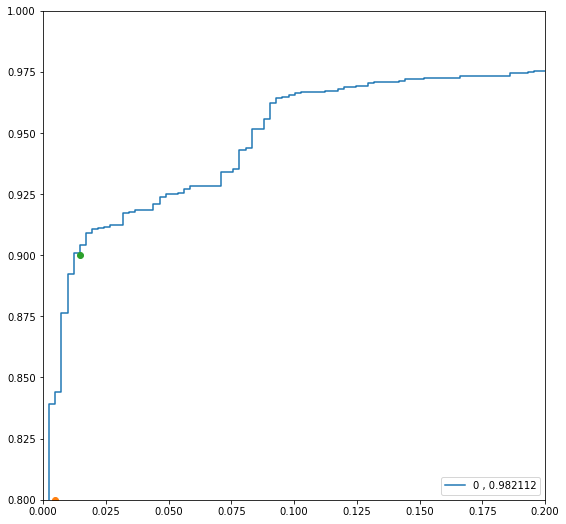

In [6]:
sum_con = []
plt.figure(0,[9,9])
plt.axis([0,0.2,0.8,1])
for i in range(5):
    bce,con = output_calc(result[i][2],result[i][1],0)
    sum_con.append(con)
    fpr, tpr, thresholds = roc_curve(result[i][1].cpu(), -bce.cpu(), pos_label=0)
    roc_auc= auc(fpr, tpr)
    fold_auc= roc_auc
    plt.plot(fpr,tpr,label='{} , {:4f}'.format(i,roc_auc))
    plt.legend(loc="lower right")
    for tpr_threshold in [0.8,0.9,0.99,0.9956]:
        plt.plot(fpr[tpr>tpr_threshold][1],tpr_threshold,'o')
        text = "fold {} TPR:{},FPR:{:.4f},Thresholds:{:.4f}".format(i,tpr_threshold,fpr[tpr>tpr_threshold][1],-thresholds[tpr>tpr_threshold][1])
        print(text)

In [ ]:
np.sum(sum_con,0)

In [ ]:
result[i][1]

In [ ]:
torch.cuda.empty_cache()
dataloaders = get_dataloaders(args, 1, fold_num, 1,DATA_DIR)
#dataloaders = get_dataloaders_all_shuffle(args,fold_num ,DATA_DIR)
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
out = out.numpy().transpose((1, 2, 0))
plt.imshow(out)
del inputs,classes,out,dataloaders

In [ ]:
output = dict()
label = dict()
bce_output = dict()
fold_auc = dict()
confusion = dict()

In [ ]:
dataloaders = get_dataloaders(args,1,fold_num ,DATA_DIR)

In [ ]:
for fold in range(5,fold_num+1):
    dataloaders = get_dataloaders(args,fold,fold_num ,DATA_DIR)
    torch.cuda.empty_cache()
    tr = train.TrainRunner(args, logger,dataloaders, fold)
    if TL_BASE != "":
        tr.load_state(TL_BASE)
    run(args,tr)
    output[fold],label[fold] = tr.test()
    bce_output[fold] = output_calc(output[fold],label[fold],0.0)
    confusion[fold] = tr.confusion[-1]

In [ ]:
#planeXfold
result = []
output = dict()
for fold in range(1, 6):
    for plane in [0, 1, 2]:
        torch.cuda.empty_cache()
        dataloaders = get_dataloaders(args, fold, fold_num, plane, DATA_DIR)
        tr = train.TrainRunner(args, logger, dataloaders, fold)
        run(args, tr)
        output[plane], label = tr.test()
        del tr
    calc_output = (output[0] + output[1] + output[2]) / 3
    _, pred = torch.max(calc_output, 1)
    logger.info("fold {} acc:{}".format(fold, sum(pred == label) / len(label)))
    logger.info("confusion_matrix:{}".format(confusion_matrix(pred, label)))
    result.append([output, label, calc_output])
torch.save(result, "result.allsave")

In [ ]:
confusion[1]+confusion[2]+confusion[3]+confusion[4]+confusion[5]

In [ ]:
output_calc(output[fold],label[fold],alpha = 0)

In [ ]:
for fold in range(1,fold_num+1):
    output[fold].cpu()
    label[fold].cpu()
    fpr, tpr, thresholds = roc_curve(label[fold].cpu(), bce_output[fold].cpu(), pos_label=0)
    roc_auc= auc(fpr, tpr)
    fold_auc[fold]= roc_auc
    plt.plot(fpr,tpr,label='{} , {:4f}'.format(fold,roc_auc))
    plt.legend(loc="lower right")
plt.show() 